In [104]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
# % get_backend()
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split

from feat_to_model_eval import feat_to_model_kfold_eval, predict_from_line
from haversine import distance_from_flatiron

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('kc_house_data.csv')

In [4]:
df, df_holdout = train_test_split(df, test_size=0.15)             
       # KEEPING A 15% HOLDOUT OF PRETEND UNSEEN DATA FOR VALIDATION
        # THE ANSWER IS CROSS VALIDATION - MOSSY THE DATA DOG

### CRISP DM
### STEP 1: Data Understanding

In [5]:
# Lets look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18357 entries, 8599 to 6434
Data columns (total 21 columns):
id               18357 non-null int64
date             18357 non-null object
price            18357 non-null float64
bedrooms         18357 non-null int64
bathrooms        18357 non-null float64
sqft_living      18357 non-null int64
sqft_lot         18357 non-null int64
floors           18357 non-null float64
waterfront       16359 non-null float64
view             18303 non-null float64
condition        18357 non-null int64
grade            18357 non-null int64
sqft_above       18357 non-null int64
sqft_basement    18357 non-null object
yr_built         18357 non-null int64
yr_renovated     15059 non-null float64
zipcode          18357 non-null int64
lat              18357 non-null float64
long             18357 non-null float64
sqft_living15    18357 non-null int64
sqft_lot15       18357 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.1+ MB


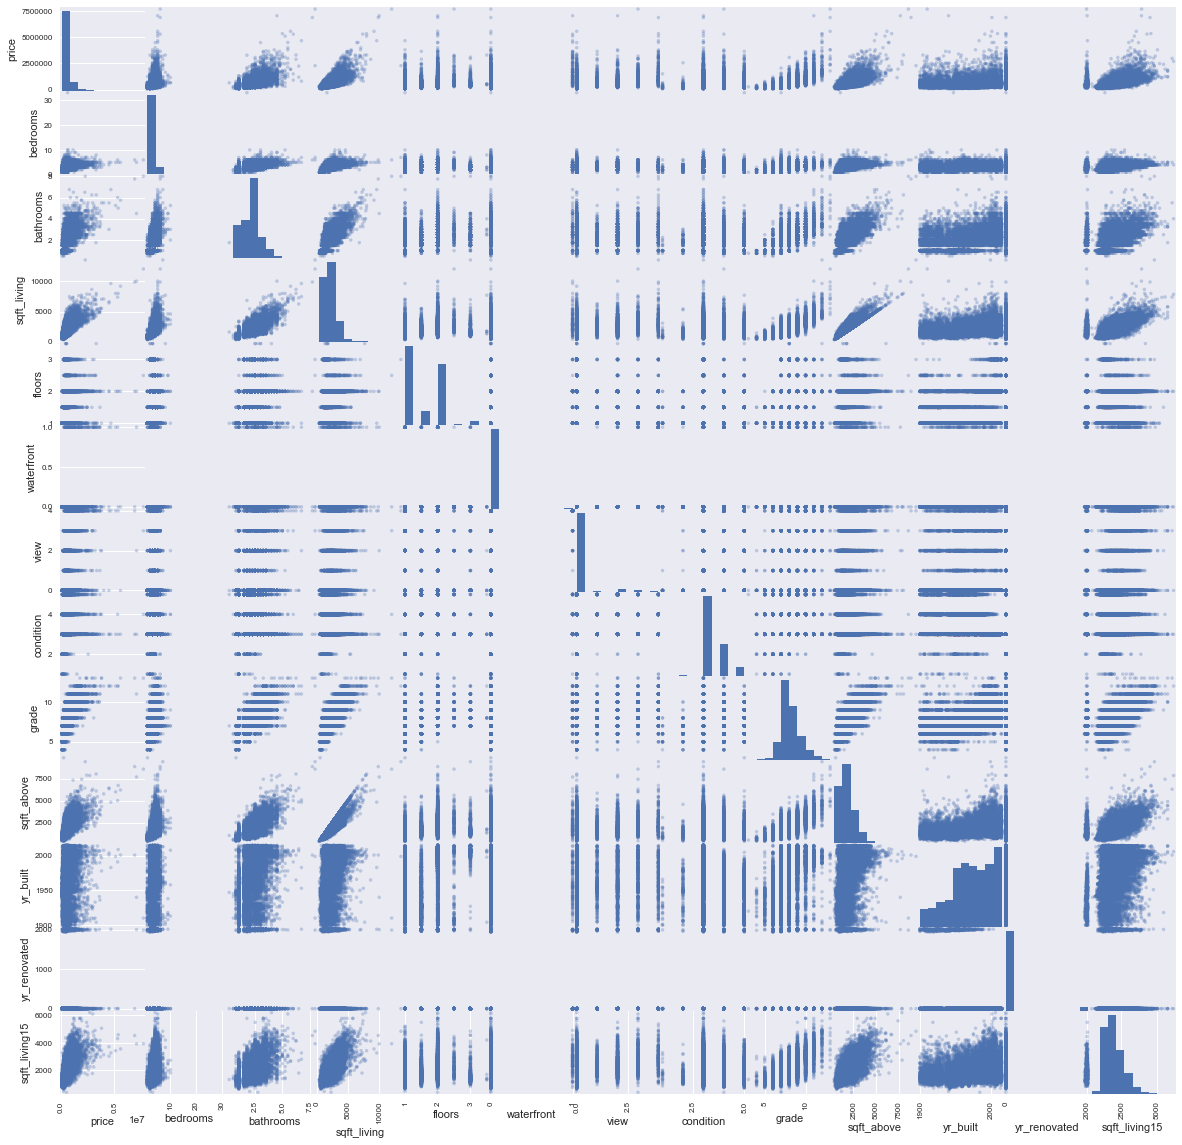

In [12]:
pd.plotting.scatter_matrix(df.drop(['id', 'date', 'sqft_basement', 'lat', 'long', 'zipcode', 'sqft_lot', 'sqft_lot15'], axis=1), figsize=(20, 20), alpha=0.3)
plt.show()

In [18]:
# LETS PICK A FEW A STRONG CANDIDATES! HOW ABOUT SQFT LIVING, SQFT LIVING 15, BATHROOM, WATERFRONT, GRADE
temp = df[['price', 'sqft_living', 'sqft_living15', 'bathrooms', 'waterfront', 'grade']]
temp.corr().price[1:]

sqft_living      0.702030
sqft_living15    0.583792
bathrooms        0.525137
waterfront       0.279525
grade            0.666611
Name: price, dtype: float64

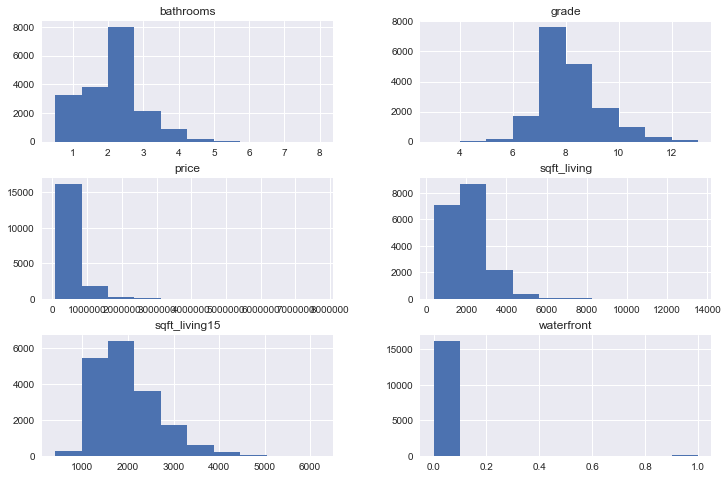

In [23]:
temp.hist(figsize=(12,8))
plt.show()

In [28]:
log_df = pd.DataFrame([])
for col in temp.drop(['waterfront'], axis=1):
    log_df[f'log_{col}'] = np.log(temp[col])
log_df.head()

,log_price,log_sqft_living,log_sqft_living15,log_bathrooms,log_grade
8599,12.793859,7.811973,7.549609,0.810930,1.945910
17959,13.035607,7.192934,7.371489,0.000000,1.945910
15182,13.217674,7.937375,7.855545,0.916291,2.197225
4771,12.423198,7.644919,7.438384,0.559616,1.945910
6015,12.513557,7.484369,7.700748,0.693147,1.945910


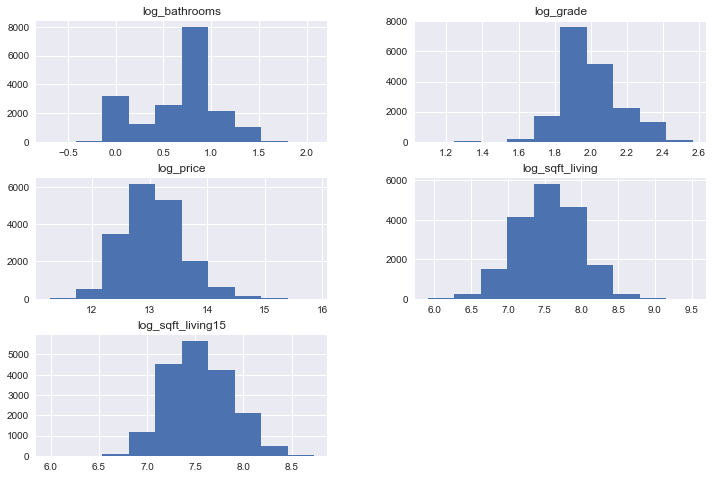

In [30]:
log_df.hist(figsize=(12,8))
plt.show()

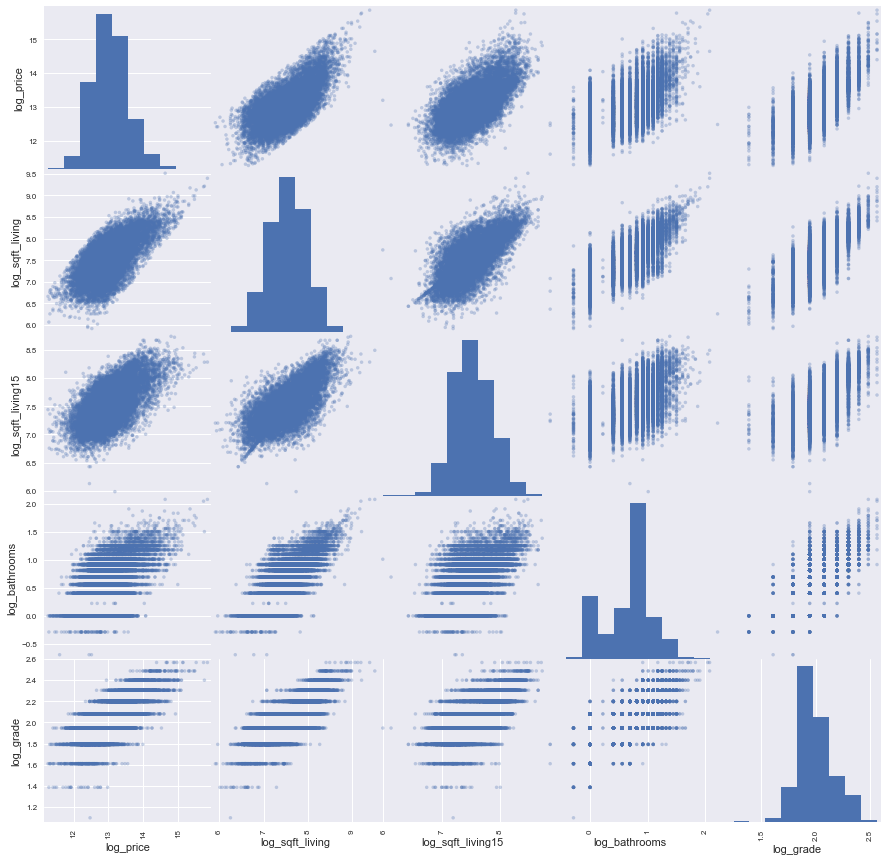

In [32]:
pd.plotting.scatter_matrix(log_df, figsize=(15,15), alpha=0.3)
plt.show()

In [35]:
log_df.corr().log_price

log_price            1.000000
log_sqft_living      0.675371
log_sqft_living15    0.608054
log_bathrooms        0.520371
log_grade            0.693795
Name: log_price, dtype: float64

In [42]:
# Lets add these to the dataframe
df = pd.concat((df, log_df), axis=1)

In [37]:
# Looks awesome! Lets check a couple other features!
df.zipcode.unique(), df.zipcode.dtype

(array([98058, 98008, 98011, 98002, 98007, 98108, 98038, 98006, 98040,
        98177, 98112, 98119, 98092, 98146, 98144, 98155, 98024, 98106,
        98198, 98004, 98023, 98059, 98103, 98116, 98105, 98126, 98001,
        98065, 98070, 98055, 98033, 98028, 98133, 98056, 98118, 98075,
        98117, 98045, 98027, 98052, 98107, 98042, 98125, 98168, 98115,
        98077, 98029, 98136, 98122, 98030, 98166, 98019, 98003, 98074,
        98010, 98178, 98032, 98022, 98034, 98005, 98072, 98031, 98199,
        98148, 98053, 98188, 98109, 98102, 98039, 98014]), dtype('int64'))

In [38]:
# Categorical  Lets Make Dummies
zip_dummies = pd.get_dummies((df.zipcode), prefix='zip')

In [41]:
zip_dummies.columns

Index(['zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98005',
       'zip_98006', 'zip_98007', 'zip_98008', 'zip_98010', 'zip_98011',
       'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024',
       'zip_98027', 'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031',
       'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038', 'zip_98039',
       'zip_98040', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_98106',
       'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115',
       'zip_98116', 'zip_98117', 'zip_98118', 'zip_98119', 'zip_98122',
       'zip_98125', 'zip_98126', 'zip_98133', 'zip_98136', 'zip_98144',
       'zip_98146', 'zip_98148', 'zip_98155', 'zip_98166', 'zip_98168',
       'zip_98177', 'zip_98178', 'zip_98188', 'zip_98198', 'zip_

In [43]:
# THATS MORE LIKE IT! Lets add these as well!
df = pd.concat((df, zip_dummies), axis=1)

In [44]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'log_price',
       'log_sqft_living', 'log_sqft_living15', 'log_bathrooms', 'log_grade',
       'zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98005',
       'zip_98006', 'zip_98007', 'zip_98008', 'zip_98010', 'zip_98011',
       'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024',
       'zip_98027', 'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031',
       'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038', 'zip_98039',
       'zip_98040', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'z

In [62]:
# Lets try a model w zips
zip_predictors = list(zip_dummies.columns)

In [73]:
feat_to_model_kfold_eval('log_price', predictors=zip_predictors, df=df, kvals=[5, 10], show_summary=True, price_logged=True, MAE=True)
print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     292.6
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:16:13   Log-Likelihood:                -7362.0
No. Observations:               18357   AIC:                         1.486e+04
Df Residuals:                   18287   BIC:                         1.541e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8730      0.003   4181.144      0.000      12.867      12.879
zip_98001     -0.3760      0.021    -18.135      0.000      -0.417      -0.335
zip_98002     -0.5305      0.027    -19.314      0.000      -0.584      -0.477
zip_98003     -0.3264      0.023    -14.159      0.000      -0.372      -0.281
zip_98004      1.1280      0.022     51.512      0.000       1.085       1.171
zip_98005      0.6780      0.030     22.361      0.000       0.619       0.737
zip_98006      0.6766      0.018     38.299      0.000       0.642       0.711
zip_98007      0.4094      0.033     12.562      0.000       0.346       0.473
zip_98008      0.4024      0.023     17.489      0.000       0.357       0.448
zip_98010     -0.0537      0.039     -1.367      0.172      -0.131       0.023
zip_98011      0.2019      0.028      7.330      0.000       0.148       0.256
zip_98014     -0.0153      0.035     -0.431      0.666      -0.085       0.054
zip_98019      0.0305      0.029      1.066      0.286      -0.026       0.086
zip_98022     -0.2715      0.025    -10.732      0.000      -0.321      -0.222
zip_98023     -0.3510      0.018    -19.917      0.000      -0.386      -0.316
zip_98024      0.2380      0.044      5.404      0.000       0.152       0.324
zip_98027      0.3737      0.019     19.337      0.000       0.336       0.412
zip_98028      0.1383      0.023      5.924      0.000       0.093       0.184
zip_98029      0.4143      0.022     19.226      0.000       0.372       0.457
zip_98030     -0.3021      0.024    -12.453      0.000      -0.350      -0.255
zip_98031     -0.2866      0.023    -12.329      0.000      -0.332      -0.241
zip_98032     -0.4744      0.035    -13.568      0.000      -0.543      -0.406
zip_98033      0.5957      0.019     31.548      0.000       0.559       0.633
zip_98034      0.2252      0.017     13.264      0.000       0.192       0.258
zip_98038     -0.1095      0.016     -6.702      0.000      -0.141      -0.077
zip_98039      1.6177      0.056     28.978      0.000       1.508       1.727
zip_98040      1.0270      0.024     43.361      0.000       0.981       1.073
zip_98042     -0.2766      0.017    -16.278      0.000      -0.310      -0.243
zip_98045      0.0473      0.026      1.841      0.066      -0.003       0.098
zip_98052      0.4616      0.016     28.256      0.000       0.430       0.494
zip_98053      0.4782      0.020     24.436      0.000       0.440       0.517
zip_98055     -0.2764      0.024    -11.570      0.000      -0.323      -0.230
zip_98056     -0.0148      0.019     -0.758      0.448      -0.053       0.023
zip_98058     -0.1462      0.018     -7.936      0.000      -0.182      -0.110
zip_98059      0.1460      0.018      8.171      0.000       0.111       0.181
zip_98065      0.2490      0.022     11.370      0.000       0.206       0.292
zi

Line: [ 1.28730308e+01 -3.76002248e-01 -5.30481917e-01 -3.26430360e-01
  1.12802894e+00  6.78008723e-01  6.76562224e-01  4.09429131e-01
  4.02416774e-01 -5.37232844e-02  2.01925260e-01 -1.53002359e-02
  3.04561389e-02 -2.71522803e-01 -3.51022845e-01  2.37988922e-01
  3.73672276e-01  1.38256831e-01  4.14340038e-01 -3.02088626e-01
 -2.86571494e-01 -4.74443489e-01  5.95720147e-01  2.25179762e-01
 -1.09470914e-01  1.61769153e+00  1.02695480e+00 -2.76646690e-01
  4.72696881e-02  4.61557626e-01  4.78245945e-01 -2.76375704e-01
 -1.47798002e-02 -1.46215811e-01  1.46040254e-01  2.48974493e-01
  1.43710924e-01  3.22695256e-01  5.11173632e-01  6.63454293e-01
  4.87421788e-01 -2.13105312e-01  6.76895495e-01  3.48983236e-01
  6.99911492e-01 -2.44855112e-01  3.56358633e-01 -1.32748264e-01
  6.99202812e-01  9.18782144e-01  4.05911379e-01  3.93971705e-01
  3.42954976e-01 -2.12942443e-02  6.64931652e-01  4.09383708e-01
  1.40935205e-01  1.47418602e-02 -3.39363038e-02  2.69464603e-01
  2.95450588e-01 -2

In [74]:
# LETS SEE WHAT EXTRA K FOLDS DOES??
feat_to_model_kfold_eval('log_price', predictors=predictors, df=df, kvals=[5, 10, 20, 40], price_logged=True, MAE=True)
print()

Line: [ 6.12539209e+00 -3.99867453e-01 -3.76818738e-01 -3.82363215e-01
  7.24959963e-01  3.19248204e-01  2.48918740e-01  2.23143958e-01
  2.75228479e-01 -1.02792220e-01  4.75028052e-03 -2.85779391e-02
 -8.65739354e-02 -2.42642666e-01 -4.39072379e-01  1.13300937e-01
  1.09772609e-01 -3.98857813e-03  1.57658727e-01 -3.67765830e-01
 -3.43978138e-01 -4.26107271e-01  3.84605738e-01  1.46830039e-01
 -2.51095542e-01  9.68563749e-01  5.29966249e-01 -3.28265919e-01
 -3.97822784e-02  2.00657751e-01  1.75138341e-01 -2.38749171e-01
 -5.83209436e-02 -2.44557643e-01 -7.82235830e-02 -2.11214629e-02
  1.47977220e-01  7.35178734e-02  1.30768046e-01  1.49573143e-01
  6.14321176e-02 -3.82020874e-01  5.44403574e-01  4.25379082e-01
  5.58463866e-01 -3.10597259e-02  4.46510165e-01 -4.89185631e-02
  5.86136291e-01  6.30002086e-01  4.15138724e-01  3.90656879e-01
  4.21447130e-01  8.09934372e-02  5.65803640e-01  3.93600440e-01
  1.84987146e-01  1.96305188e-01  6.46584769e-02  3.19423170e-01
  2.85084176e-01 -5

In [75]:
# LETS TRY THE LOGS
log_predictors = list(log_df.drop(['log_price'], axis=1).columns)
feat_to_model_kfold_eval('log_price', predictors=log_predictors, df=df, kvals=[5, 10], price_logged=True, MAE=True)
print()

Line: [ 5.59608586  0.42091884  0.18904352 -0.10141417  1.44049346]
RMSE: 255529.64102462673
MAE: 151909.03098861137
MAE DISPLAYED



In [76]:
# WHAT ABOUT LOG AND ZIPS?
zip_log_predictors = zip_predictors + log_predictors
feat_to_model_kfold_eval('log_price', predictors=zip_log_predictors, df=df, kvals=[5, 10], price_logged=True, MAE=True)
print()

Line: [ 6.12539209e+00 -3.99867453e-01 -3.76818738e-01 -3.82363215e-01
  7.24959963e-01  3.19248204e-01  2.48918740e-01  2.23143958e-01
  2.75228479e-01 -1.02792220e-01  4.75028052e-03 -2.85779391e-02
 -8.65739354e-02 -2.42642666e-01 -4.39072379e-01  1.13300937e-01
  1.09772609e-01 -3.98857813e-03  1.57658727e-01 -3.67765830e-01
 -3.43978138e-01 -4.26107271e-01  3.84605738e-01  1.46830039e-01
 -2.51095542e-01  9.68563749e-01  5.29966249e-01 -3.28265919e-01
 -3.97822784e-02  2.00657751e-01  1.75138341e-01 -2.38749171e-01
 -5.83209436e-02 -2.44557643e-01 -7.82235830e-02 -2.11214629e-02
  1.47977220e-01  7.35178734e-02  1.30768046e-01  1.49573143e-01
  6.14321176e-02 -3.82020874e-01  5.44403574e-01  4.25379082e-01
  5.58463866e-01 -3.10597259e-02  4.46510165e-01 -4.89185631e-02
  5.86136291e-01  6.30002086e-01  4.15138724e-01  3.90656879e-01
  4.21447130e-01  8.09934372e-02  5.65803640e-01  3.93600440e-01
  1.84987146e-01  1.96305188e-01  6.46584769e-02  3.19423170e-01
  2.85084176e-01 -5

In [77]:
# WHAT AN IMPROVEMENT!!!

In [78]:
df['coords'] = list(zip(
        round(df.lat, 6), 
        round(df.long, 6)))

In [81]:
df['dist_flatiron'] = df.coords.apply(distance_from_flatiron)

In [82]:
df.dist_flatiron.head()

8599     23.115335
17959    16.067923
15182    19.038022
4771     34.631852
6015     23.236587
Name: dist_flatiron, dtype: float64

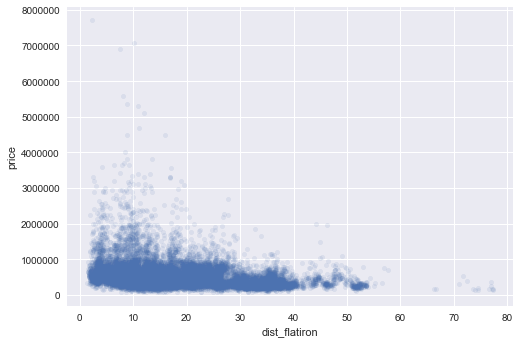

-0.35767485946930555

In [92]:
df.plot.scatter('dist_flatiron', 'price', alpha=0.1)
plt.show()
df.log_price.corr(df.dist_flatiron)

In [83]:
zip_log_dist_predictors = zip_log_predictors + ['dist_flatiron']

In [94]:
feat_to_model_kfold_eval('log_price', predictors=zip_log_dist_predictors, df=df, kvals=[5, 10], price_logged=True, MAE=True)
print()

Line: [ 6.33937178 -0.23671249 -0.20352204 -0.23052139  0.63269505  0.25743921
  0.21440237  0.18010942  0.25284734  0.12781357  0.00919012  0.17103741
  0.05635333  0.10892325 -0.27815383  0.2653388   0.17045152 -0.01711922
  0.23094956 -0.25708415 -0.27095421 -0.34046497  0.33047128  0.1133223
 -0.07303276  0.85357533  0.43872303 -0.1854282   0.25446784  0.19595854
  0.24310749 -0.22913589 -0.08665716 -0.19515815 -0.06643026  0.17225236
  0.19812835  0.10881266  0.16644027  0.20430661  0.13797479 -0.18720094
  0.37574714  0.30220042  0.43227226 -0.14209207  0.32345639 -0.17488656
  0.41963055  0.46828047  0.30829207  0.25389853  0.31798777 -0.02700986
  0.40802348  0.22192057  0.11422409  0.0794704   0.01314144  0.21357603
  0.12611748 -0.1256436  -0.24030034  0.02652138 -0.03586764 -0.34489306
  0.18442654 -0.24064951 -0.28721381 -0.2065306   0.33775565  0.46880134
  0.23979433 -0.03206408  0.74201383 -0.01079236]
RMSE: 171073.76591257023
MAE: 83532.4669453522
MAE DISPLAYED



In [93]:
# WHAT IF WE NEVER LOGGED PRICE???
feat_to_model_kfold_eval('price', predictors=zip_log_dist_predictors, df=df, kvals=[5, 10], MAE=True)
print()

Line: [-3.69543233e+06 -2.07869037e+05 -1.35400187e+05 -2.23430454e+05
  4.89939019e+05 -8.23326791e+03 -1.07266319e+03 -7.92643208e+04
  1.21052300e+03 -6.22571600e+04 -1.80488695e+05 -3.42069671e+04
 -1.34816475e+05 -5.38376378e+04 -2.45183195e+05  1.74397920e+04
 -7.77975006e+04 -1.79040686e+05 -6.80385223e+04 -2.42510162e+05
 -2.49126723e+05 -2.33698761e+05  7.29083478e+04 -7.87244941e+04
 -1.87080361e+05  1.18914591e+06  2.80713147e+05 -2.05136875e+05
 -3.03697208e+04 -7.75459954e+04 -4.28391388e+04 -2.11669570e+05
 -1.68028486e+05 -2.34830493e+05 -1.95609527e+05 -9.90756085e+04
 -4.03929875e+04 -1.23559835e+05 -9.80620270e+04 -7.02763428e+04
 -1.12361801e+05 -2.37174934e+05  1.62537172e+05  1.75072174e+04
  1.72073433e+05 -1.50439224e+05  2.40554632e+04 -1.98499876e+05
  1.60983046e+05  2.82846529e+05  2.13675363e+04 -5.47551394e+03
  2.02925426e+04 -1.15117267e+05  1.35508837e+05 -1.54723343e+04
 -8.03268357e+04 -7.68495539e+04 -1.29066698e+05 -2.95378737e+04
 -2.94837797e+04 -1

In [100]:
#LOG PRICE IS DOLPHINATELY BETTER... FOR SHARK
#   MAYBE LOG DISTANCE WOULD BE HELPFUL
df['log_dist_flatiron'] = np.log(df.dist_flatiron)

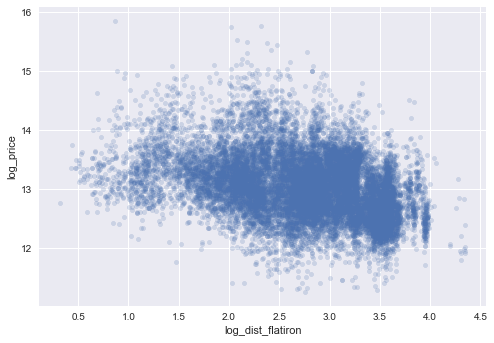

In [102]:
df.plot.scatter('log_dist_flatiron', 'log_price', alpha=0.2)

In [96]:
zip_log_logdist_predictors = zip_log_predictors + ['log_dist_flatiron']

In [108]:
feat_to_model_kfold_eval(
    'log_price', predictors=zip_log_logdist_predictors, 
    df=df, kvals=[5, 10], show_summary=True, price_logged=True, MAE=True)
print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1395.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:41:41   Log-Likelihood:                 3192.7
No. Observations:               18357   AIC:                            -6235.
Df Residuals:                   18282   BIC:                            -5649.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.6664      0.058    115.154      0.000       6.553       6.780
zip_98001            -0.2245      0.015    -14.757      0.000      -0.254      -0.195
zip_98002            -0.1946      0.019    -10.504      0.000      -0.231      -0.158
zip_98003            -0.2135      0.016    -13.331      0.000      -0.245      -0.182
zip_98004             0.6442      0.013     48.252      0.000       0.618       0.670
zip_98005             0.2913      0.017     16.854      0.000       0.257       0.325
zip_98006             0.2576      0.010     25.045      0.000       0.237       0.278
zip_98007             0.2230      0.018     12.132      0.000       0.187       0.259
zip_98008             0.3010      0.013     23.048      0.000       0.275       0.327
zip_98010             0.1087      0.025      4.336      0.000       0.060       0.158
zip_98011             0.0591      0.016      3.724      0.000       0.028       0.090
zip_98014             0.1585      0.023      7.036      0.000       0.114       0.203
zip_98019             0.0761      0.018      4.118      0.000       0.040       0.112
zip_98022             0.0216      0.020      1.055      0.291      -0.019       0.062
zip_98023            -0.2642      0.014    -19.002      0.000      -0.291      -0.237
zip_98024             0.2823      0.027     10.638      0.000       0.230       0.334
zip_98027             0.2136      0.012     17.208      0.000       0.189       0.238
zip_98028             0.0318      0.013      2.382      0.017       0.006       0.058
zip_98029             0.2744      0.014     19.803      0.000       0.247       0.302
zip_98030            -0.2244      0.016    -14.184      0.000      -0.255      -0.193
zip_98031            -0.2278      0.015    -15.599      0.000      -0.256      -0.199
zip_98032            -0.3002      0.021    -14.356      0.000      -0.341      -0.259
zip_98033             0.3681      0.011     34.252      0.000       0.347       0.389
zip_98034             0.1584      0.010     16.505      0.000       0.140       0.177
zip_98038            -0.0667      0.014     -4.825      0.000      -0.094      -0.040
zip_98039             0.8378      0.032     25.825      0.000       0.774       0.901
zip_98040             0.4490      0.014     31.226      0.000       0.421       0.477
zip_98042            -0.1648      0.013    -12.474      0.000      -0.191      -0.139
zip_98045             0.2015      0.020     10.219      0.000       0.163       0.240
zip_98052             0.2450      0.010     25.393      0.000       0.226       0.264
zip_98053             0.2865      0.013     22.456      0.000       0.261       0.311
zip_98055            -0.1791      0.014    -12.913      0.000      -0.206      -0.152
zip_98056            -0.0402      0.011     -3.637      0.000      -0.062

Line: [ 6.66639431e+00 -2.24493269e-01 -1.94628446e-01 -2.13524833e-01
  6.44177586e-01  2.91299220e-01  2.57552053e-01  2.22986349e-01
  3.01048499e-01  1.08693499e-01  5.90722306e-02  1.58505745e-01
  7.61063825e-02  2.15871111e-02 -2.64190539e-01  2.82252553e-01
  2.13639878e-01  3.17634963e-02  2.74402093e-01 -2.24414033e-01
 -2.27839563e-01 -3.00192015e-01  3.68068745e-01  1.58366720e-01
 -6.67019403e-02  8.37843742e-01  4.48984480e-01 -1.64750672e-01
  2.01492336e-01  2.45035361e-01  2.86492324e-01 -1.79071722e-01
 -4.01689805e-02 -1.48097983e-01 -1.70850327e-02  1.70924563e-01
  2.42036838e-01  1.57408478e-01  2.15176197e-01  2.48882620e-01
  1.79054711e-01 -1.88882644e-01  2.01430902e-01  2.71697607e-01
  4.00074676e-01 -1.50252642e-01  2.98771742e-01 -2.07219082e-01
  2.61707766e-01  3.32053857e-01  3.06321464e-01  2.01129723e-01
  3.20952330e-01 -3.27387124e-02  2.91019819e-01  3.73284421e-02
  1.44570878e-01  6.02141280e-02  5.09940015e-02  2.12325951e-01
  4.73118221e-03 -9

In [115]:
# NOT MUCH DIF, logbathroom is negative coef, interesting, lets try with bathrooms instead of logbathrooms
try_predictors = zip_predictors + ['log_sqft_living', 'log_sqft_living15', 'bathrooms', 'log_grade', 'log_dist_flatiron']
feat_to_model_kfold_eval('log_price', predictors=try_predictors, df=df, kvals=[5, 10], show_summary=True, price_logged=True,  MAE=True)
print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1392.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:47:37   Log-Likelihood:                 3181.4
No. Observations:               18357   AIC:                            -6213.
Df Residuals:                   18282   BIC:                            -5626.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.8755      0.057    120.469      0.000       6.764       6.987
zip_98001            -0.2239      0.015    -14.707      0.000      -0.254      -0.194
zip_98002            -0.1956      0.019    -10.552      0.000      -0.232      -0.159
zip_98003            -0.2124      0.016    -13.252      0.000      -0.244      -0.181
zip_98004             0.6505      0.013     48.735      0.000       0.624       0.677
zip_98005             0.2962      0.017     17.123      0.000       0.262       0.330
zip_98006             0.2626      0.010     25.530      0.000       0.242       0.283
zip_98007             0.2269      0.018     12.334      0.000       0.191       0.263
zip_98008             0.3049      0.013     23.320      0.000       0.279       0.331
zip_98010             0.1110      0.025      4.426      0.000       0.062       0.160
zip_98011             0.0594      0.016      3.742      0.000       0.028       0.091
zip_98014             0.1606      0.023      7.123      0.000       0.116       0.205
zip_98019             0.0735      0.018      3.976      0.000       0.037       0.110
zip_98022             0.0219      0.020      1.069      0.285      -0.018       0.062
zip_98023            -0.2627      0.014    -18.883      0.000      -0.290      -0.235
zip_98024             0.2847      0.027     10.726      0.000       0.233       0.337
zip_98027             0.2130      0.012     17.150      0.000       0.189       0.237
zip_98028             0.0342      0.013      2.562      0.010       0.008       0.060
zip_98029             0.2698      0.014     19.467      0.000       0.243       0.297
zip_98030            -0.2260      0.016    -14.276      0.000      -0.257      -0.195
zip_98031            -0.2301      0.015    -15.745      0.000      -0.259      -0.201
zip_98032            -0.2934      0.021    -14.025      0.000      -0.334      -0.252
zip_98033             0.3712      0.011     34.523      0.000       0.350       0.392
zip_98034             0.1588      0.010     16.543      0.000       0.140       0.178
zip_98038            -0.0718      0.014     -5.192      0.000      -0.099      -0.045
zip_98039             0.8436      0.032     26.000      0.000       0.780       0.907
zip_98040             0.4541      0.014     31.579      0.000       0.426       0.482
zip_98042            -0.1660      0.013    -12.563      0.000      -0.192      -0.140
zip_98045             0.2013      0.020     10.205      0.000       0.163       0.240
zip_98052             0.2467      0.010     25.541      0.000       0.228       0.266
zip_98053             0.2878      0.013     22.547      0.000       0.263       0.313
zip_98055            -0.1772      0.014    -12.771      0.000      -0.204      -0.150
zip_98056            -0.0375      0.011     -3.393      0.001      -0.059

Line: [ 6.87547029 -0.22387024 -0.19563215 -0.21240794  0.6505448   0.29622193
  0.26259159  0.22688581  0.30493566  0.11101724  0.05940939  0.16056525
  0.07351715  0.02188824 -0.26272572  0.28473426  0.21304888  0.03419941
  0.26984969 -0.22598557 -0.23005989 -0.29344115  0.37117362  0.15883174
 -0.07177732  0.84363422  0.45408143 -0.16600195  0.20134521  0.2467189
  0.28784005 -0.17720824 -0.03749184 -0.14610945 -0.0154937   0.16790291
  0.24696795  0.16091313  0.21763149  0.25092732  0.18511015 -0.18893092
  0.20604491  0.27518569  0.40452787 -0.14891114  0.29762704 -0.20426694
  0.26806409  0.3398545   0.31315862  0.2060011   0.32678001 -0.02696734
  0.29491993  0.04052409  0.15060181  0.06703306  0.05632102  0.21750149
  0.00873058 -0.08773192 -0.18833735  0.07935981  0.01834844 -0.29758822
  0.23000716 -0.19461201 -0.23231194 -0.15760285  0.29785744  0.44039772
  0.24876698  0.00877276  0.70711094 -0.20975146]
RMSE: 170810.17227299523
MAE: 83552.10792246049
MAE DISPLAYED



In [116]:
# DIDN'T REALLY CHANGE MUCH



In [ ]:
## ADD PREDICTORRRR